<a href="https://colab.research.google.com/github/rkhamilton/vqgan-clip-generator/blob/main/vqgan_clip_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VQGAN_CLIP_GENERATOR**
Documentation is provided at [the project home page](https://github.com/rkhamilton/vqgan-clip-generator).

This is a package (with available notebook) for running VQGAN+CLIP locally, with a focus on ease of use, good documentation, and generating smooth style transfer videos. There are [three main user-facing functions](https://github.com/rkhamilton/vqgan-clip-generator#functions): generate.image(), generate.video_frames(), and generate.style_transfer().

This package started as a complete refactor/rewrite of the code provided by [NerdyRodent](https://github.com/nerdyrodent/), which started out as a Katherine Crowson VQGAN+CLIP-derived Google colab notebook.

In addition to refactoring NerdyRodent's code into a more pythonic package to improve usability, this project includes the following noteable elements:
* Significant improvements to the quality of style transfer videos
* Video smoothing/deflicker by applying EWMA to latent vector series
* A wrapper for Real-ESRGAN for  unit tests
* Improvements to generated image quality derived from the use of NerdyRodent's cut method code
* Example code for video includes optical flow interpolation using RIFE
* A google colab notebook (this file)

This package is compatible with all of the usual trained models that work with VQGAN (sflickr, coco, etc). Code is provided here only for ImageNet for simplicity. You can see in the [documentation how to use alternate models](https://github.com/rkhamilton/vqgan-clip-generator#dynamic-model-download-and-caching).

Note that with a typical Colab runtime you will have 16 GB of VRAM. That will support images up to 700x700 image (933x525 in 16:9 format). Bigger images are significantly slower to generate, but tend to have many more details (more than just an upscaled version of a lower resolution file). The free tier Colab account is likely to be too slow to generate more than single images at the maximum size.

In [ ]:
#@title MIT License
# 

# Copyright (c) 2021 Ryan Hamilton

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
#@markdown What GPU am I using?

#@markdown V100 > P100 > everything else

!nvidia-smi --query-gpu=gpu_name,memory.used,memory.total,gpu_bus_id,vbios_version --format=csv
gpu_name = !nvidia-smi --query-gpu=gpu_name, --format=csv

name, memory.used [MiB], memory.total [MiB], pci.bus_id, vbios_version
Tesla P100-PCIE-16GB, 0 MiB, 16280 MiB, 00000000:00:04.0, 86.00.52.00.02


# **Filesystem Setup**
Run **one** of the Filesystem blocks below to set your root location.

In [3]:
#@title Use Google Drive as your Filesystem
#@markdown This option connects to your google drive, and saves model files and outputs to that location for re-use.
import os
abs_root_path = "/content"

from google.colab import drive
drive.mount('/content/drive')

def ensureProperRootPath():
    if len(abs_root_path) > 0:
        os.chdir(abs_root_path) # Changes directory to absolute root path
        print("Root path check: ")
        !pwd

ensureProperRootPath()

def make_folder(folder_name):
  if len(folder_name) > 0:
      path_tmp = os.path.join("/content/drive/MyDrive/",folder_name)
      if not os.path.exists(path_tmp):
          os.mkdir(path_tmp)
      return path_tmp


project_folder_name = "VQGAN_CLIP_GENERATOR" #@param {type: "string"}
abs_root_path = make_folder(project_folder_name)

print("Created folder & set root path to: " + abs_root_path)
%cd $abs_root_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root path check: 
/content
Created folder & set root path to: /content/drive/MyDrive/VQGAN_CLIP_GENERATOR
/content/drive/MyDrive/VQGAN_CLIP_GENERATOR


In [ ]:
#@title Use Local Google Colab Filesystem
#@markdown If you use the local google filesystem, all data will be lost at the
#@markdown end of the session. VQGAN models will have to be re-downloaded.
import os
abs_root_path = "/content"
def ensureProperRootPath():
    if len(abs_root_path) > 0:
        os.chdir(abs_root_path) # Changes directory to absolute root path
        print("Root path check: ")
        !pwd

ensureProperRootPath()
print("Your root directory is: ")
!pwd

def make_folder(folder_name):
  abs_root_path = "/content"
  if len(folder_name) > 0:
      path_tmp = abs_root_path + "/drive/MyDrive/" + folder_name
      if not os.path.exists(path_tmp):
          os.mkdir(path_tmp)
      return path_tmp
%cd $abs_root_path

# **Download Dependencies for Google Colab**

In [4]:
#@title Download dependencies
#@markdown Needed every time you connect to a fresh colab runtime.
! pip install torch_optimizer==0.1.0                                      > /dev/null
!pip install git+https://github.com/openai/CLIP.git                       > /dev/null
!pip install git+https://github.com/rkhamilton/vqgan-clip-generator.git   > /dev/null
!pip install opencv-python scipy                                          > /dev/null
!pip install basicsr                                                      > /dev/null
!pip install facexlib                                                     > /dev/null
!pip install gfpgan                                                       > /dev/null
!pip install git+https://github.com/xinntao/Real-ESRGAN                   > /dev/null
!pip install sk-video                                                     > /dev/null
!pip install opencv-python                                                > /dev/null
!pip install moviepy                                                      > /dev/null
!pip install piexif                                                       > /dev/null

  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-p9i1eiod
  Running command git clone -q https://github.com/rkhamilton/vqgan-clip-generator.git /tmp/pip-req-build-m36boifz
  Running command git clone -q https://github.com/xinntao/Real-ESRGAN /tmp/pip-req-build-hzfv1jel


In [ ]:
#@title Download RIFE and pre-trained model
#@markdown Only needed once for initial setup to download this pacakge to your Google Drive.
!git clone https://github.com/hzwer/arXiv2020-RIFE                      > /dev/null

os.makedirs(f'arXiv2020-RIFE/train_log',exist_ok=True)
!curl -L -o 'arXiv2020-RIFE/RIFE_trained_model_v3.8.zip' -C - 'https://drive.google.com/u/0/uc?id=1O5KfS3KzZCY3imeCr2LCsntLhutKuAqj&export=download'
!unzip 'arXiv2020-RIFE/RIFE_trained_model_v3.8.zip' -d arXiv2020-RIFE

# **Define Paths and Import libraries**
Run this once every time you reset your runtime.

In [5]:
#@title Paths
import os
extracted_video_frames_dir = os.path.join(abs_root_path, "extracted_video_frames")
generated_video_frames_path = os.path.join(abs_root_path, "generated_video_frames")
upscaled_video_frames_path = os.path.join(abs_root_path, "upscaled_video_frames")

output_dir = os.path.join(abs_root_path, "output")
models_dir = os.path.join(abs_root_path, "models")

make_folder(extracted_video_frames_dir)
make_folder(generated_video_frames_path)
make_folder(upscaled_video_frames_path)
make_folder(output_dir)
make_folder(models_dir)

print(f'abs_root_path:\t\t\t{abs_root_path}')
print(f'output_dir:\t\t\t{output_dir}')
print(f'generated_video_frames_path:\t{generated_video_frames_path}')
print(f'extracted_video_frames_dir:\t{extracted_video_frames_dir}')
print(f'upscaled_video_frames_path:\t{upscaled_video_frames_path}')
print(f'models_dir:\t\t\t{models_dir}')


abs_root_path:			/content/drive/MyDrive/VQGAN_CLIP_GENERATOR
output_dir:			/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output
generated_video_frames_path:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/generated_video_frames
extracted_video_frames_dir:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/extracted_video_frames
upscaled_video_frames_path:	/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/upscaled_video_frames
models_dir:			/content/drive/MyDrive/VQGAN_CLIP_GENERATOR/models


In [6]:
#@title Libraries
from vqgan_clip import generate, esrgan, video_tools
from vqgan_clip.engine import VQGAN_CLIP_Config
import os
from vqgan_clip import _functional as VF

from IPython import display
import subprocess
from tqdm.auto import tqdm

# **Generate a single image from a prompt**
This section lets you generate an image using any combination of text prompts (most common) and image prompts. An initial image may also be uploaded to your project root folder and used.

Generated image saved to: /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/my_image.jpg


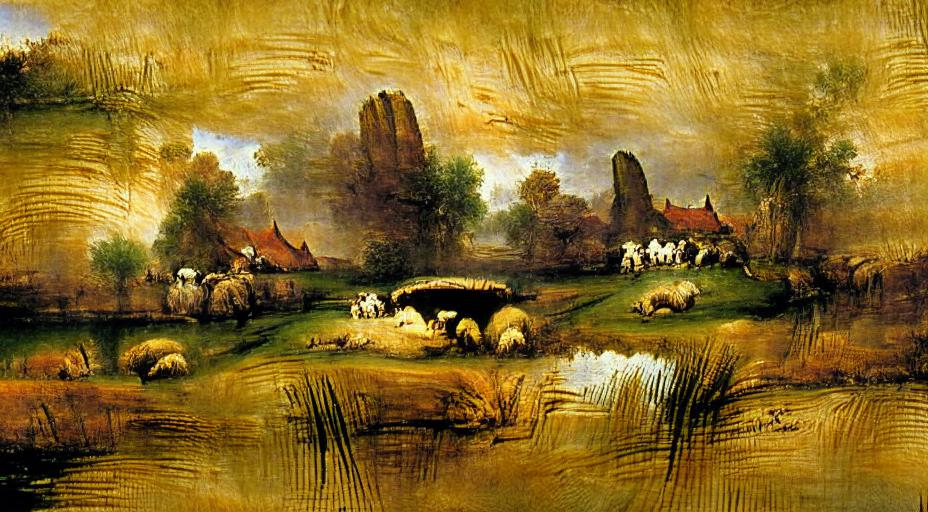

Real-ESRGAN:   0%|          | 0/1 [00:00<?, ?image/s]

single image:   0%|          | 0/500 [00:00<?, ?iteration/s]

Generated image saved to: /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/my_image.jpg


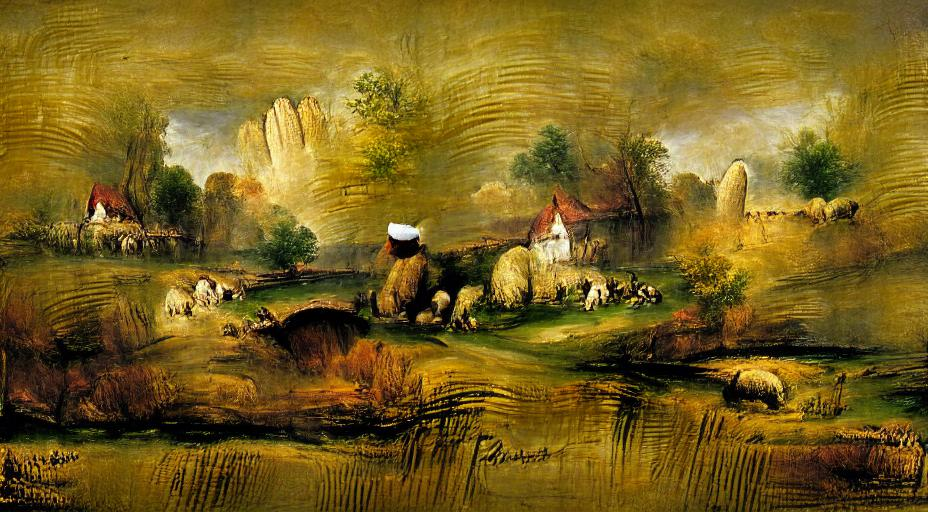

Real-ESRGAN:   0%|          | 0/1 [00:00<?, ?image/s]

Generated image saved to: /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/my_image_upscaled.jpg


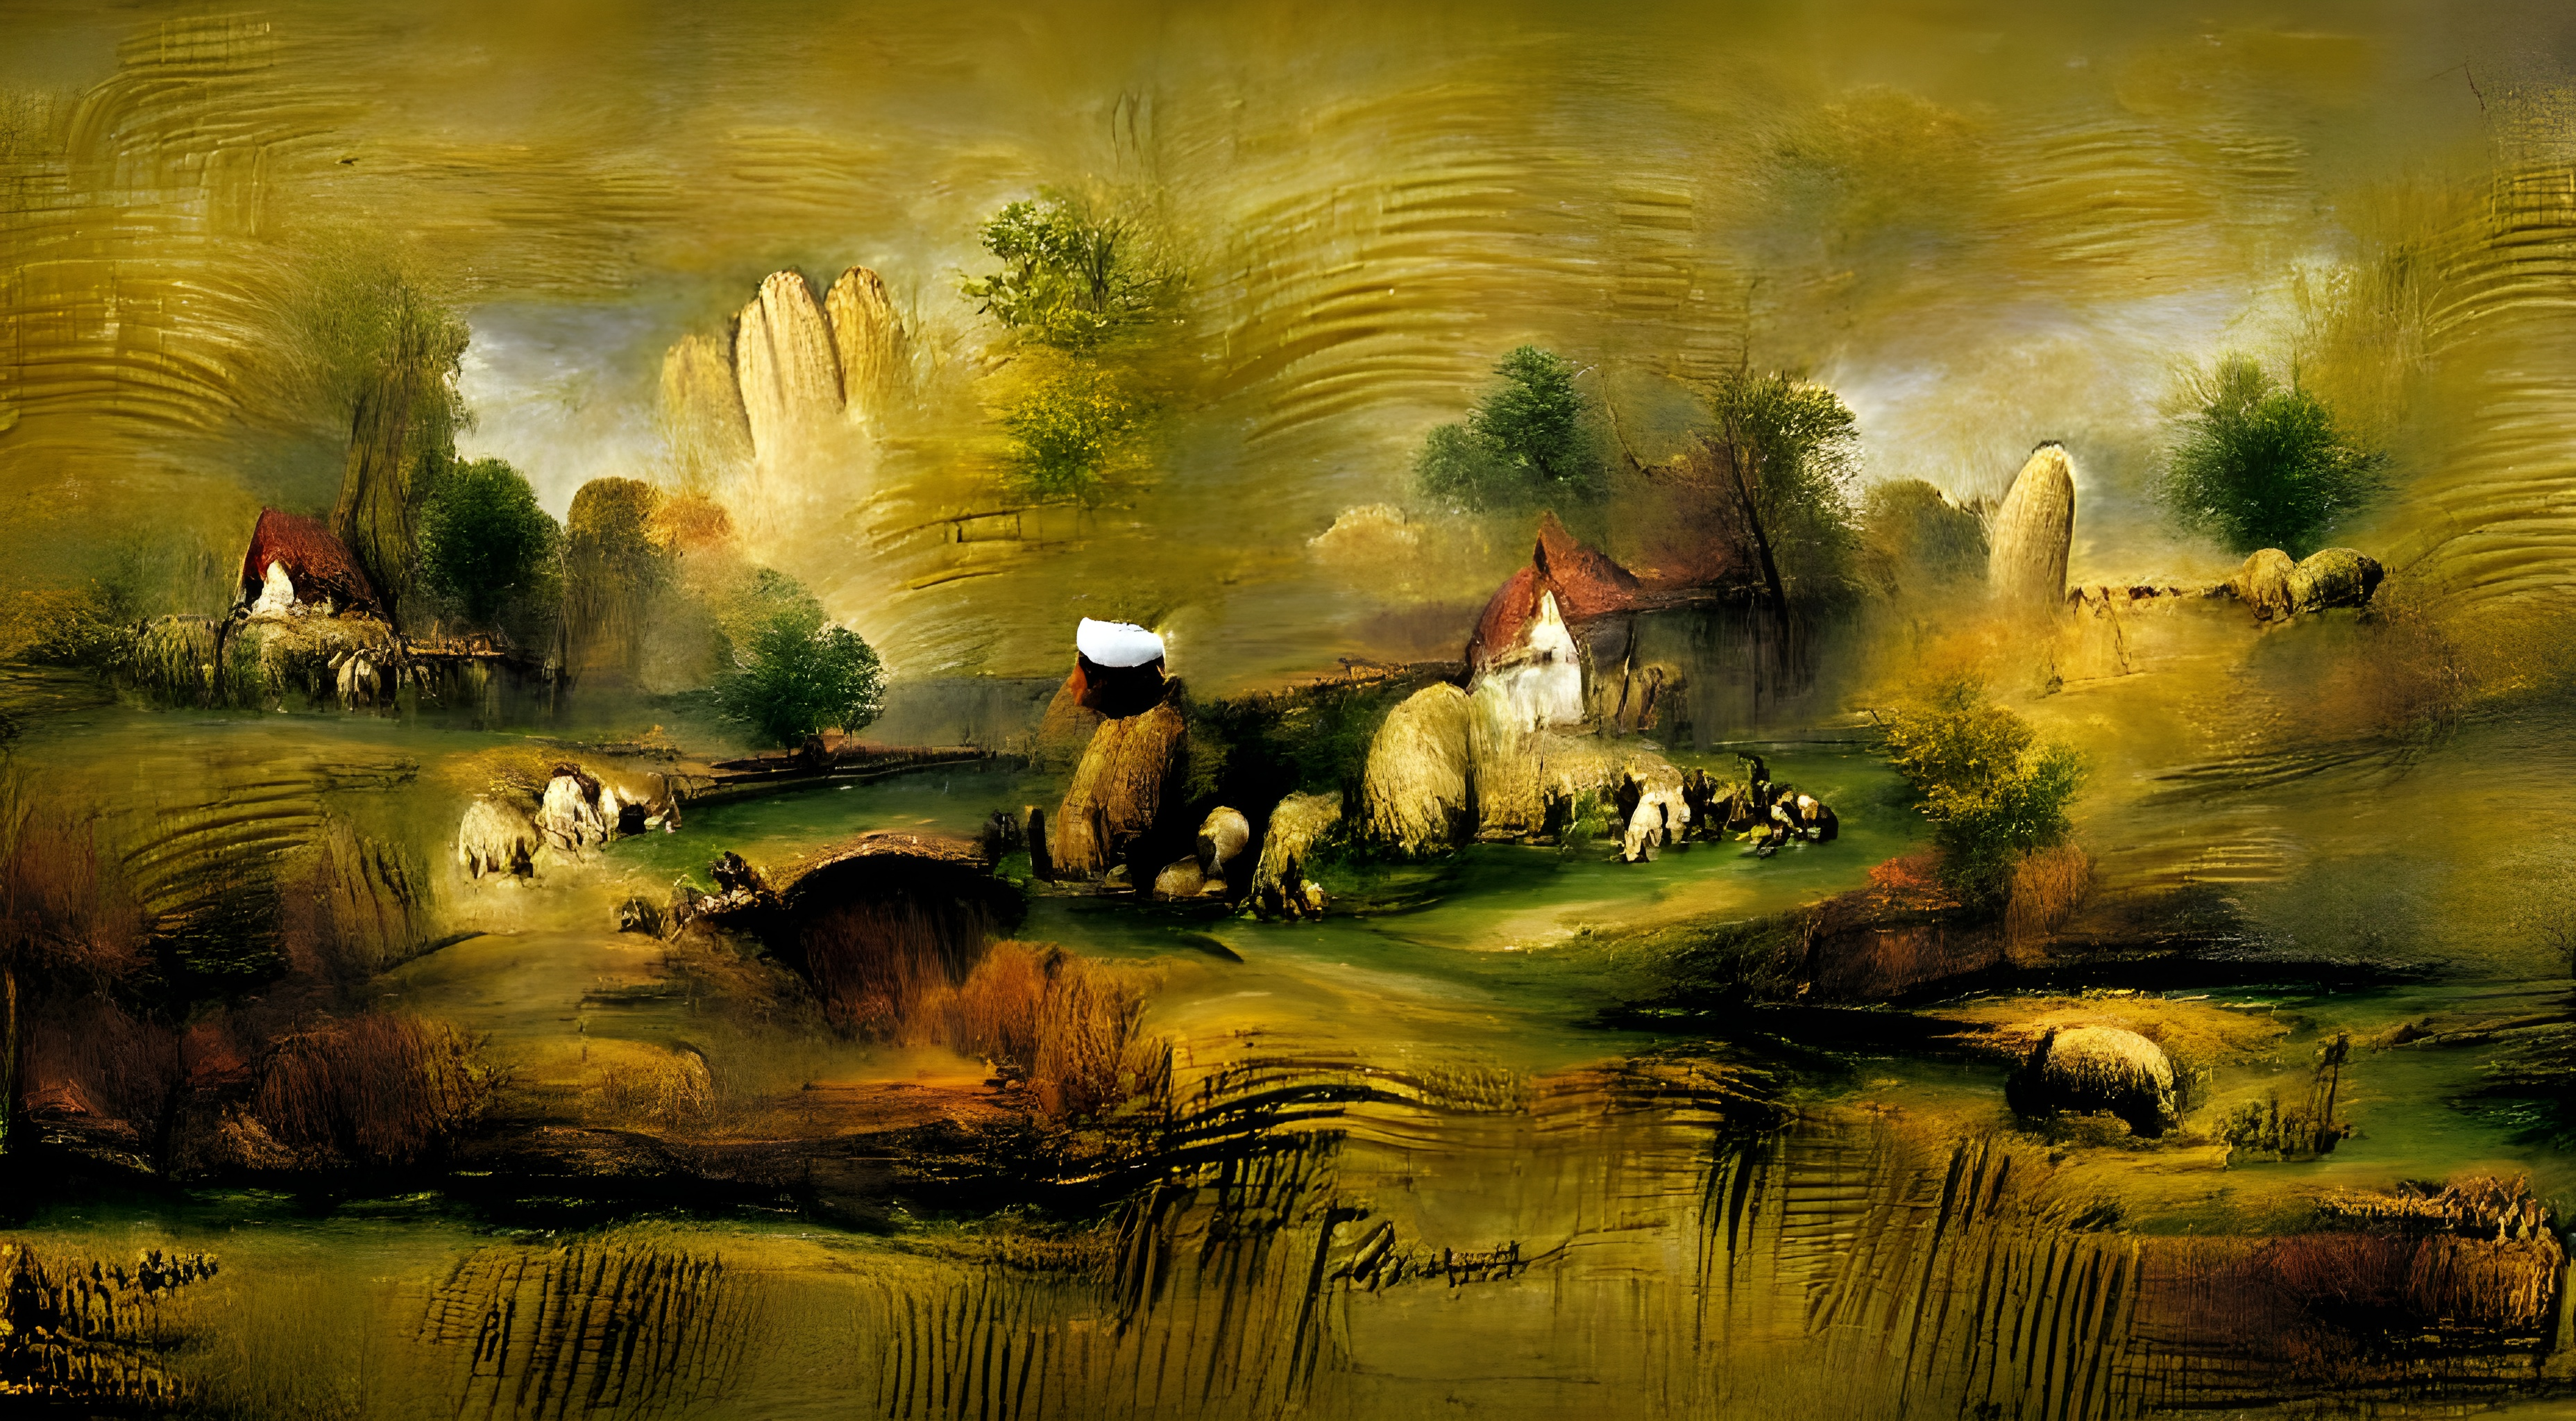

In [7]:
#@title Generate the image
config = VQGAN_CLIP_Config()
config.model_dir = models_dir
output_image_width_pixels = 933 #@param {type: "integer"}
output_image_height_pixels =  525#@param {type: "integer"}
config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
text_prompts = 'A pastoral landscape painting by Rembrandt' #@param {type: "string"}
iterations =  500 #@param {type: "integer"}
upscale_image = True #@param {type: "boolean"}

output_filename = os.path.join(output_dir,'my_image.jpg')
generate.image(eng_config = config,
        text_prompts = text_prompts,
        iterations = iterations,
        output_filename = output_filename)

print(f'Generated image saved to: {output_filename}')
display.display(display.Image(output_filename))

#@markdown Upscale the image
if upscale_image:
  esrgan.inference_realesrgan(input=output_filename,
          output_images_path=output_dir,
          model_dir=models_dir,
          face_enhance=False)

  upscaled_filename = os.path.splitext(output_filename)[0] + '_upscaled.jpg'
  print(f'Generated image saved to: {upscaled_filename}')
  display.display(display.Image(upscaled_filename))

# **Generate a zoom video**
This section lets you create generate many images and combine them into a video. The generated images will change over time as VQGAN+CLIP progresses. You may also change the text or image prompts over time (e.g. at frame 60 change to a new prompt).

In [11]:
#@title Setup paths and parameters
#@markdown Generate a video with movement. Every frame that is generated has a shift or zoom applied to it.
#@markdown This gives the appearance of motion in the result.
#@markdown This is one of the most interesting application of VQGAN+CLIP here.

config = VQGAN_CLIP_Config()
config.model_dir=models_dir
#@markdown See [the documentation](https://github.com/rkhamilton/vqgan-clip-generator#prompts) for syntax for parallel and sequential prompts.
text_prompts = 'a pastoral landscape in the impressionist style ^ flaming bales of hay in the impressionist style' #@param {type: "string"}
init_image = None #@param {type: "raw"}
output_image_width_pixels = 933 #@param {type: "integer"}
output_image_height_pixels =  525#@param {type: "integer"}
config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
num_video_frames = 150 #@param {type: "integer"}
iterations_per_frame = 30 #@param {type: "integer"}
#@markdown It can take a few extra iterations for the first frame of video to stabilize from a gray field. Increase this number if you need to.
iterations_for_first_frame = 30 #@param {type: "integer"}
#@markdown Set change_prompts_on_frame to [60, 150] to e.g. change prompts on frames 60 and 150
change_prompts_on_frame= [30]#@param {type: "raw"}
#@markdown Framerate to use when encoding the video. If you have 150 frames at 15 fps you will get a 10 second video.
video_framerate = 15  #@param {type: "integer"}
final_video_filename = 'muppets.mp4' #@param {type: "string"}

#@markdown Zoom/Shift - if you use these parameters, you will need more iterations_per_frame than if you do not.

#@markdown After every frame of video, it will zoom in/out by this ratio for the next frame.
zoom_scale=1.02  #@param {type: "number"}
#@markdown Pixels to shift left/right/up/down after each frame
shift_x=0 #@param {type: "integer"}
shift_y=0 #@param {type: "integer"}
output_file_path = os.path.join(output_dir, final_video_filename)

video_frames_to_encode = generated_video_frames_path
# This will be overwritten when we create the video
metadata_comment = ''
#@markdown Use adaptive learning rate to have a video that settles into a still image when content doesn't change 
config.adaptiveLR = False #@param {type: "boolean"}

#@markdown Set True if you want to use the Real-ESRGAN package for upscaling. face_enhance is a feature of Real-ESRGAN.
#@markdown Some detail will be lost / blurred if you use Real-ESRGAN.
upscale_images = True #@param {type: "boolean"}
face_enhance = False #@param {type: "boolean"}

# encode the generated frames by default, but override with upscaled images if needed
video_frames_to_encode = generated_video_frames_path
#@markdown Use RIFE optical flow interpolation to increase the framerate of the resulting video.
interpolation_with_RIFE = False #@param {type: "boolean"}


In [9]:
#@title Generate a zoom video
metadata_comment = generate.video_frames(num_video_frames=num_video_frames,
        eng_config = config,
        text_prompts = text_prompts,
        init_image = init_image,
        generated_video_frames_path = generated_video_frames_path,
        iterations_per_frame = iterations_per_frame,
        iterations_for_first_frame = iterations_for_first_frame,
        change_prompts_on_frame= change_prompts_on_frame,
        zoom_scale=zoom_scale, 
        shift_x=shift_x, 
        shift_y=shift_y,
        z_smoother=True,
        z_smoother_buffer_len=5,
        z_smoother_alpha=0.9)

#@markdown Upscale the video frames (optional)
if upscale_images:
  esrgan.inference_realesrgan(input=generated_video_frames_path,
                              output_images_path=upscaled_video_frames_path,
                              face_enhance=False,
                              model_dir=models_dir,
                              purge_existing_files=True,
                              model_filename='RealESRGAN_x4plus_anime_6B.pth',
                              model_url='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth',
                              netscale=4,
                              outscale=4)
  video_frames_to_encode = upscaled_video_frames_path

#@markdown Encode the video frames to MP4
video_tools.encode_video(output_file=output_file_path,
                         path_to_stills=video_frames_to_encode,
                         metadata_title=text_prompts,
                         metadata_comment=metadata_comment,
                         input_framerate=video_framerate)
print(f'Video with saved as: {output_file_path}')

#@markdown Use optical flow interpolation with RIFE
if interpolation_with_RIFE:
  output_RIFE=f'{os.path.splitext(output_file_path)[0]}_RIFE.mp4'
  video_tools.RIFE_interpolation(input=output_file_path,
                      output=output_RIFE,
                      interpolation_factor=4,
                      metadata_title=text_prompts,
                      metadata_comment=metadata_comment)
  print(f'Video with interpolation saved as: {output_RIFE}')

NameError: ignored

In [ ]:
#@title Download video from Google Colab using the browser
#@markdown If you are using the Google Drive filesystem, the file is already 
#@markdown stored there. Running this block lets you download it through your browser.
from google.colab import files
files.download(output_file_path)

In [ ]:
#@title Download RIFE interpolated video from Google Colab using the browser
#@markdown If you are using the Google Drive filesystem, the file is already 
#@markdown stored there. Running this block lets you download it through your browser.
from google.colab import files
files.download(output_RIFE)

# **Style transfer to an existing video**
Apply a VQGAN+CLIP style to an existing video. Sequential / parallel prompts are supported (e.g. you can change from prompt 1 to prompt 2 at frame 30). You must balance the iterations_per_frame and current_source_frame_image_weight. See [the documentation](https://github.com/rkhamilton/vqgan-clip-generator#style-transfer) for tips.

In [ ]:
#@title Setup paths and parameters
#@markdown An existing video will have a VQGAN style applied to each frame.
#@markdown Refer to the [documentation](https://github.com/rkhamilton/vqgan-clip-generator/blob/main/README.md) 
#@markdown for an explanation of the options.

config = VQGAN_CLIP_Config()
config.model_dir = models_dir
input_video_path = '20211004_132008000_iOS.MOV' #@param {type: "string"}
output_video_filename = 'style_transfer_video.mp4' #@param {type: "string"}
extraction_framerate = 30 #@param {type: "integer"}
text_prompts = 'portrait covered in spiders charcoal drawing' #@param {type: "string"}
#@markdown Set change_prompts_on_frame to [60, 150] to e.g. change prompts on frames 60 and 150
change_prompts_on_frame = None#@param {type: "raw"}
output_image_width_pixels = 684 #@param {type: "integer"}
output_image_height_pixels = 384 #@param {type: "integer"}
iterations_per_frame = 60 #@param {type: "integer"}
iterations_for_first_frame = 20 #@param {type: "integer"}
#@markdown Effects how closely the output video will be to the source video image. Values of 0.5-8.0 are reasonable.
current_source_frame_image_weight = 3.2 #@param {type: "number"}
#@markdown Effects how closely the output video will be to the source video content. Values of 0.0-1.0 are reasonable.
current_source_frame_prompt_weight=0.0 #@param {type: "number"}

config.output_image_size = [output_image_width_pixels,output_image_height_pixels]
init_image = f'{output_dir}{os.sep}init_image.jpg'
output_video_path = f'{output_dir}{os.sep}{output_video_filename}'
video_frames_to_encode = generated_video_frames_path
metadata_comment = ''
generated_video_no_audio=f'{output_dir}{os.sep}output_no_audio.mp4'

#@markdown Set True if you want to use the Real-ESRGAN package for upscaling. face_enhance is a feature of Real-ESRGAN.
#@markdown Some detail will be lost / blurred if you use Real-ESRGAN.
upscale_images = True #@param {type: "boolean"}
face_enhance = False #@param {type: "boolean"}

#@markdown Check here if you want to copy the audio from the original video to the style transfer video.
copy_audio = True #@param {type: "boolean"}

In [ ]:
#@title  Perform the style transfer

#@markdown Extract frames from your source video
original_video_frames = video_tools.extract_video_frames(input_video_path, 
        extraction_framerate = extraction_framerate,
        extracted_video_frames_path=extracted_video_frames_dir)

#@markdown Apply a style to the extracted video frames.
metadata_comment = generate.style_transfer(original_video_frames,
                                           eng_config=config,
                                           current_source_frame_image_weight=current_source_frame_image_weight,
                                           current_source_frame_prompt_weight=current_source_frame_prompt_weight,
                                           text_prompts=text_prompts,
                                           iterations_per_frame=iterations_per_frame,
                                           iterations_for_first_frame=iterations_for_first_frame,
                                           change_prompts_on_frame=change_prompts_on_frame,
                                           generated_video_frames_path=generated_video_frames_path,
                                           z_smoother=True,
                                           z_smoother_alpha=0.9,
                                           z_smoother_buffer_len=3)

#@markdown Upscale the styled video frames using Real-ESRGAN
if face_enhance:
  esrgan.inference_realesrgan(input=generated_video_frames_path,
          output_images_path=upscaled_video_frames_path,
          face_enhance=face_enhance,
          purge_existing_files=True,
          model_dir=models_dir)
  video_frames_to_encode = upscaled_video_frames_path

#@markdown Use a wrapper for FFMPEG to encode the images into a video
video_tools.encode_video(output_file=output_video_path,
        path_to_stills=video_frames_to_encode,
        metadata_title=text_prompts,
        metadata_comment=metadata_comment,
        input_framerate=extraction_framerate)

#@markdown Copy audio from the original video into your generated video (optional)
if copy_audio:
  tempfile = f'{output_dir}{os.sep}temp.mp4'
  video_tools.copy_video_audio(input_video_path, output_video_path, tempfile)
  if os.path.exists(tempfile):
    os.remove(output_video_path)
    os.rename(tempfile,output_video_path)

#@markdown Use optical flow interpolation with RIFE.
#@markdown This creates a separate video with '_RIFE' at the end of the filename.
if interpolation_with_RIFE:
  video_tools.RIFE_interpolation(input=output_video_path,
                      output=f'{os.path.splitext(output_video_path)[0]}_RIFE.mp4',
                      interpolation_factor=4,
                      metadata_title=text_prompts,
                      metadata_comment=metadata_comment)

In [ ]:
#@title Download video from Google Colab using the browser
#@markdown If you are using the Google Drive filesystem, the file is already 
#@markdown stored there. Running this block lets you download it through your browser.
from google.colab import files
files.download(output_video_path)

# **Create images using many prompts by combining with keywords**
Combine your text prompt with many phrases that will strongly influence the look of the result. E.g. "my prompt rendered by Unreal Engine"  
This generates over 130 images, so it can take a long time to run.

art type:   0%|          | 0/133 [00:00<?, ?style/s]

single image:   0%|          | 0/500 [00:00<?, ?iteration/s]

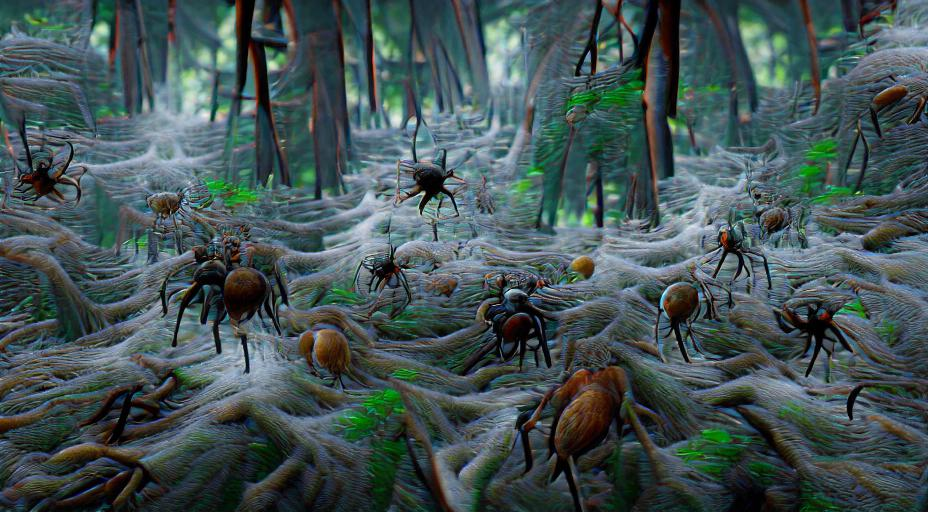

single image:   0%|          | 0/500 [00:00<?, ?iteration/s]

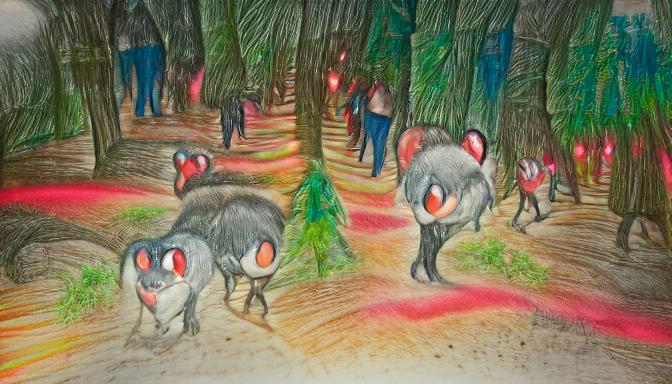

single image:   0%|          | 0/500 [00:00<?, ?iteration/s]

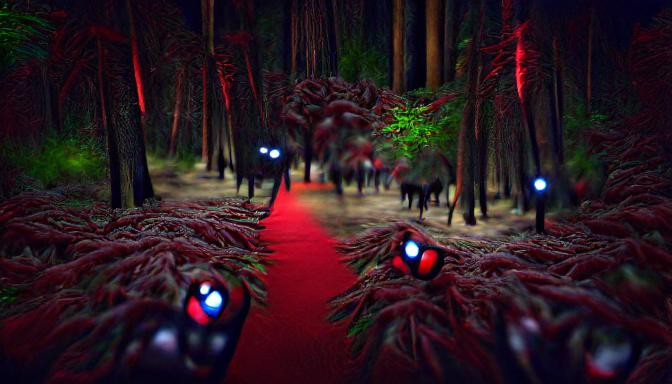

KeyboardInterrupt: ignored

In [ ]:
#@title Generate the images
config = VQGAN_CLIP_Config()
config.model_dir = models_dir
text_prompts = 'the forest is full of spiders' #@param {type: "string"}
#@markdown Path to image if you want an initial image. Otherwise None.
image_prompts=None #@param {type: "raw"}
output_image_width_pixels = 933 #@param {type: "integer"}
output_image_height_pixels =  525#@param {type: "integer"}
config.output_image_size = [output_image_width_pixels, output_image_height_pixels]
iterations_per_image = 500 #@param {type: "integer"}
output_root_dir = output_dir
generated_images_path = os.path.join(output_root_dir, 'multi_prompt')
upscaled_video_frames_path = os.path.join(
    output_root_dir, 'multi_prompt upscaled')
#@markdown Set True if you want to use the Real-ESRGAN package for upscaling. face_enhance is a feature of Real-ESRGAN.
#@markdown Some detail will be lost / blurred if you use Real-ESRGAN.
upscale_images = False #@param {type: "boolean"}
face_enhance = False #@param {type: "boolean"}

art_types = ["8k resolution", "pencil sketch", "8K 3D", "deviantart", "CryEngine",
             "Unreal Engine", "photo illustration", "pixiv", "Flickr", "Artstation HD",
             "Behance HD", "HDR", "anime", "Ambient occlusion", "Global illumination",
             "Chat art", "Low poly", "Booru", "Polycount", "Acrylic Art", "Hyperrealism",
             "Zbrush Central", "Rendered in Cinema4D", "Rendered in Maya", "Tilt Shift",
             "Mixed Media", "Detailed painting", "Volumetric lighting",
             "Storybook Illustration", "#vfxfriday", "Ultrafine detail", "matte painting",
             "Watercolor", "CGSocity", "child's drawing", "marble sculpture", "airbrush art",
             "renaissance painting", "Velvia", "dye-transfer", "stipple", "Parrallax",
             "Bryce 3D", "Terragen", "charcoal drawing", "commission for",
             "polished", "aftereffects", "datamosh", "holographic", "dutch golden age",
             "digitally enhanced", "Art on Instagram", "bokeh", "psychedelic", "wavy",
             "groovy", "movie poster", "pop art", "made of beads and yarn", "made of feathers",
             "made of crystals", "made of liquid metal", "made of glass", "made of cardboard",
             "made of vines", "made of flowers", "made of insects", "made of mist",
             "made of paperclips", "made of rubber", "made of wire", "made of trash",
             "made of wrought iron", "tattoo", "woodcut", "American propaganda",
             "Soviet propaganda", "Fine Art", "Photorealism", "drone shot",
             "poster art", "Impressionism", "Lowbrow", "Egyptian art", "filmic", "stock photo",
             "DSLR", "in the style of Rembrandt", "Provia", "criterion collection", "flat shading",
             "ink drawing", "oil on canvas", "#film", "national geographic photo", "associate press photo", 
             "digital illustration", "made of insects", "made of plastic", "pre-Raphaelite", 
             "chiaroscuro", "masterpiece", "art deco", "picasso", "Da Vinci", "cubism",
             "surrealist", "DC comics", "Marvel Comics", "Ukiyo-e", "Flemish Baroque", 
             "vray tracing", "Bob Ross", "photocopy", "infrared", "angelic photograph",
             "biomorphic", "physically based rendering", "concert poster", "steampunk",
             "trending on artstation", "instax", "ilford HPS", "matte drawing", "by Ed Hopper",
             "Kodak Portra", "Rococo", "by James Gurney", "by Thomas Kinkade", "by Paul Cezanne", 
             "biomechanical", "from Studio Ghibli"]

for art_type in tqdm(art_types, unit='style', desc='art type'):
    output_filename=f'{generated_images_path}{os.sep}{art_type}.jpg'
    metadata_comment = generate.image(eng_config=config,
                                      text_prompts=text_prompts + ' ' + art_type,
                                      image_prompts=image_prompts,
                                      iterations=iterations_per_image,
                                      save_every=None,
                                      output_filename=output_filename,
                                      leave_progress_bar=False)
    display.display(display.Image(output_filename))

# Upscale the image
if upscale_images:
    esrgan.inference_realesrgan(input=generated_images_path,
                                output_images_path=upscaled_video_frames_path,
                                face_enhance=face_enhance,
                                purge_existing_files=True,
                                netscale=4,
                                outscale=4)
    # copy image metadata from generated images to upscaled images
    VF.copy_image_metadata(generated_images_path, upscaled_video_frames_path)
print(f'generation parameters: {metadata_comment}')
print(f'Images saved to {generated_images_path}')
if upscale_images:
  print(f'Upscaled images saved to {upscaled_video_frames_path}')

# **Create many variants of the same prompt using different random seeds**
If you have a prompt (plus keywords) that you like, this block runs it repeatedly with different random starts so you can pick your favorite version.

random seeds:   0%|          | 0/3 [00:00<?, ?image/s]

single image:   0%|          | 0/200 [00:00<?, ?iteration/s]

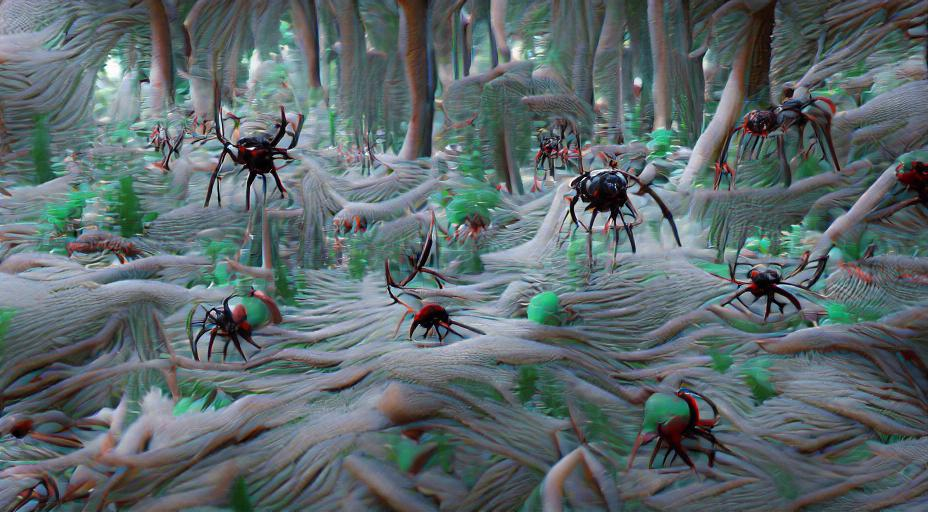

single image:   0%|          | 0/200 [00:00<?, ?iteration/s]

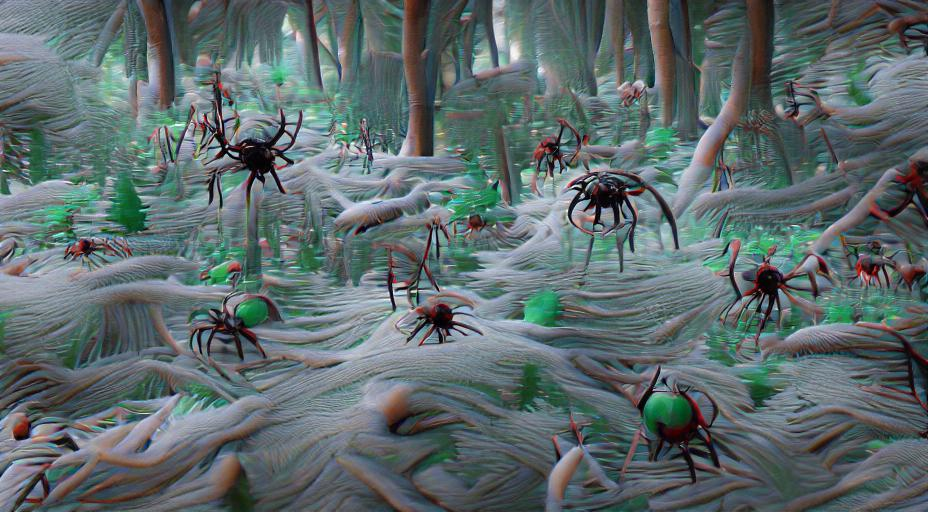

single image:   0%|          | 0/200 [00:00<?, ?iteration/s]

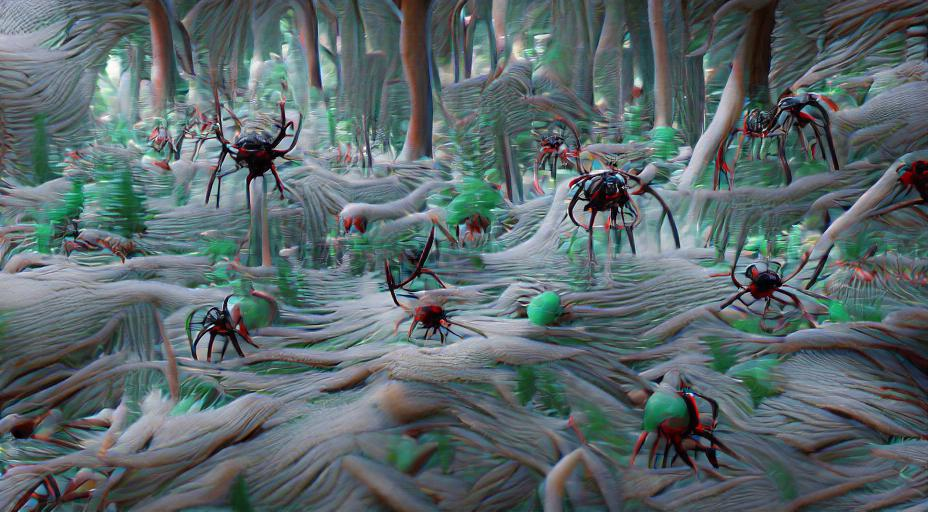

Real-ESRGAN:   0%|          | 0/3 [00:00<?, ?image/s]

generation parameters: iterations: 200, image_prompts: [], noise_prompts: [], init_weight_method: original, init_weight 0.00, init_image None, seed 353114804105616833
Images saved to /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/multi_seed
Upscaled images saved to /content/drive/MyDrive/VQGAN_CLIP_GENERATOR/output/multi_seed upscaled


In [ ]:
#@title Generate the images
config = VQGAN_CLIP_Config()
config.model_dir = models_dir
text_prompts = 'the forest is full of spiders 8K 3D' #@param {type: "string"}
#@markdown Path to image if you want an initial image. Otherwise None.
image_prompts=None #@param {type: "raw"}
output_image_width_pixels = 933 #@param {type: "integer"}
output_image_height_pixels = 525 #@param {type: "integer"}
config.output_image_size = [output_image_width_pixels, output_image_height_pixels]
iterations_per_image = 500 #@param {type: "integer"}
number_images_to_generate =  3#@param {type: "integer"}
output_root_dir = output_dir
generated_images_path = os.path.join(output_root_dir, 'multi_seed')
upscaled_video_frames_path = os.path.join(
    output_root_dir, 'multi_seed upscaled')
#@markdown Set True if you want to use the Real-ESRGAN package for upscaling. face_enhance is a feature of Real-ESRGAN.
#@markdown Some detail will be lost / blurred if you use Real-ESRGAN.
upscale_images = True #@param {type: "boolean"}
face_enhance = False #@param {type: "boolean"}

for image_number in tqdm(range(1, number_images_to_generate+1), unit='image', desc='random seeds'):
    output_filename=f'{generated_images_path}{os.sep}frame_{image_number:012d}.jpg'
    metadata_comment = generate.image(eng_config=config,
                                      text_prompts=text_prompts,
                                      iterations=200,
                                      save_every=50,
                                      output_filename=output_filename,
                                      leave_progress_bar=False)
    display.display(display.Image(output_filename))

# Upscale the image
if upscale_images:
    esrgan.inference_realesrgan(input=generated_images_path,
                                output_images_path=upscaled_video_frames_path,
                                face_enhance=face_enhance,
                                purge_existing_files=True,
                                netscale=4,
                                outscale=4)
    # copy metadata from generated images to upscaled images.
    VF.copy_image_metadata(generated_images_path, upscaled_video_frames_path)
print(f'generation parameters: {metadata_comment}')
print(f'Images saved to {generated_images_path}')
if upscale_images:
  print(f'Upscaled images saved to {upscaled_video_frames_path}')